In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import traceback
import re
from pandas import Series
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import warnings
import os
import collections
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

**USERS**

In [2]:
users = pd.read_csv('takehome_users.csv',encoding = 'ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.drop_duplicates(inplace=True)

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 1.0+ MB


In [5]:
#To confirm invited by user ID has a user ID, which they do for guest and org invites. Others are regular signups.
users.groupby('creation_source').count().T

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,2163,4254,2111,2087,1385
creation_time,2163,4254,2111,2087,1385
name,2163,4254,2111,2087,1385
email,2163,4254,2111,2087,1385
last_session_creation_time,1588,3188,764,1898,1385
opted_in_to_mailing_list,2163,4254,2111,2087,1385
enabled_for_marketing_drip,2163,4254,2111,2087,1385
org_id,2163,4254,2111,2087,1385
invited_by_user_id,2163,4254,0,0,0


In [6]:
users.invited_by_user_id.fillna(0,inplace=True)
users['invited_by_user'] = np.where(users['invited_by_user_id']==0,0,1)

In [7]:
users.tail()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,1
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,1
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0,0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,0.0,0


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  invited_by_user             12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 1.1+ MB


In [9]:
users.last_session_creation_time.head()

0    1.398139e+09
1    1.396238e+09
2    1.363735e+09
3    1.369210e+09
4    1.358850e+09
Name: last_session_creation_time, dtype: float64

In [10]:
users.creation_time = pd.to_datetime(users.creation_time)
#last session creation time is in UNIX timestamp, need to convert to correct date format with unit = 's'
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time,unit='s')


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  invited_by_user             12000 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(4), 

In [12]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1


In [13]:
#users.last_session_creation_time.fillna(0,inplace=True)
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], errors='coerce')
users['last_session_creation_time'] = np.where(users['last_session_creation_time'].isnull(), users['creation_time'], users['last_session_creation_time'])
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  invited_by_user             12000 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(4), 

In [14]:
users['active_days'] =  users['last_session_creation_time'] - users['creation_time'] 
users.active_days.max()

Timedelta('729 days 00:00:00')

In [15]:
#users.active_days.fillna(pd.Timedelta(seconds=0),inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   object_id                   12000 non-null  int64          
 1   creation_time               12000 non-null  datetime64[ns] 
 2   name                        12000 non-null  object         
 3   email                       12000 non-null  object         
 4   creation_source             12000 non-null  object         
 5   last_session_creation_time  12000 non-null  datetime64[ns] 
 6   opted_in_to_mailing_list    12000 non-null  int64          
 7   enabled_for_marketing_drip  12000 non-null  int64          
 8   org_id                      12000 non-null  int64          
 9   invited_by_user_id          12000 non-null  float64        
 10  invited_by_user             12000 non-null  int32          
 11  active_days                 12000 non-nul

In [16]:
users.active_days.nunique()

512

In [17]:
users.active_days = (users.active_days / np.timedelta64(1, 'D')).astype(int)

In [18]:
users['active_years'] = round(users['active_days']/365,2)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  invited_by_user             12000 non-null  int32         
 11  active_days                 12000 non-null  int32     

In [19]:
max_yr = users.active_years.max()
min_yr = users.active_years.min()
print(max_yr)
print(min_yr)

2.0
0.0


In [20]:
users.sort_values('active_years')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user,active_days,active_years
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,0,0.00
7104,7105,2014-01-02 09:38:09,Rocha Manuela,ManuelaCorreiaRocha@gustr.com,ORG_INVITE,2014-01-02 09:38:09,1,0,191,389.0,1,0,0.00
7105,7106,2012-10-11 02:20:30,Hoch Anna,AnnaHoch@yahoo.com,ORG_INVITE,2012-10-12 02:20:30,0,0,2,3801.0,1,1,0.00
7107,7108,2013-12-06 20:27:48,Thorsen Silke,SilkeBThorsen@yahoo.com,PERSONAL_PROJECTS,2013-12-06 20:27:48,1,1,0,0.0,0,0,0.00
7108,7109,2014-03-14 16:31:44,Reeves Bradley,BradleyReeves@yahoo.com,SIGNUP,2014-03-15 16:31:44,0,0,134,0.0,0,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8258,8259,2012-06-05 15:04:44,Wechsler Karin,KarinWechsler@gmail.com,ORG_INVITE,2014-06-02 15:04:44,0,0,160,3885.0,1,727,1.99
8279,8280,2012-06-09 13:39:42,Hanson Mohammed,hrpwoegq@nrwjd.com,ORG_INVITE,2014-06-04 13:39:42,0,0,317,8280.0,1,725,1.99
2567,2568,2012-06-02 16:44:54,Morrison James,shezmjmi@dpqmm.com,SIGNUP,2014-05-29 16:44:54,0,0,314,0.0,0,726,1.99
7106,7107,2012-06-09 01:51:47,Burgess Keira,KeiraBurgess@gmail.com,SIGNUP_GOOGLE_AUTH,2014-06-04 01:51:47,0,0,399,0.0,0,725,1.99


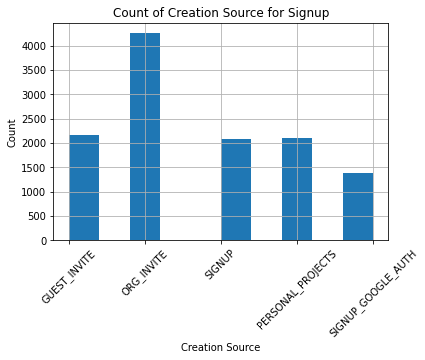

In [21]:
users.creation_source.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Creation Source for Signup')
plt.xlabel('Creation Source')
plt.ylabel('Count');

In [22]:
user_engagement= pd.read_csv('takehome_user_engagement.csv',encoding = 'ISO-8859-1')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [23]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [26]:
user_engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [29]:
user_engagement = user_engagement.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])[['visited']].count()
user_engagement = user_engagement.reset_index()

# getting weekly count max per user
user_engagement = user_engagement.groupby('user_id')['visited'].max()
user_engagement = user_engagement.reset_index()

# determining adopted users
user_engagement['adopted_user'] = np.where(user_engagement['visited'] >= 3, 1, 0)
user_engagement.head()

,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


In [30]:
user_engagement.adopted_user.sum()

1445

In [31]:
users.rename(columns={'object_id':'user_id'}, inplace=True)
df = user_engagement.merge(users, how='inner', on='user_id', sort=True)
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user,active_days,active_years
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,0,0.00
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,136,0.37
2,3,1,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1,0,0.00
3,4,1,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1,1,0.00
4,5,1,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1,5,0.01


In [32]:
table1 = pd.pivot_table(df, values='adopted_user', index=['creation_source'],
                    columns=['invited_by_user'], aggfunc=np.sum)
table1

invited_by_user,0,1
creation_source,,
GUEST_INVITE,NaN,326.0
ORG_INVITE,NaN,491.0
PERSONAL_PROJECTS,147.0,NaN
SIGNUP,275.0,NaN
SIGNUP_GOOGLE_AUTH,206.0,NaN


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   visited                     8823 non-null   int64         
 2   adopted_user                8823 non-null   int32         
 3   creation_time               8823 non-null   datetime64[ns]
 4   name                        8823 non-null   object        
 5   email                       8823 non-null   object        
 6   creation_source             8823 non-null   object        
 7   last_session_creation_time  8823 non-null   datetime64[ns]
 8   opted_in_to_mailing_list    8823 non-null   int64         
 9   enabled_for_marketing_drip  8823 non-null   int64         
 10  org_id                      8823 non-null   int64         
 11  invited_by_user_id          8823 non-null   float64     

In [36]:
table1 = pd.pivot_table(df, values='adopted_user', index=['creation_source'],
                    columns=['invited_by_user'], aggfunc=np.sum)
table1

invited_by_user,0,1
creation_source,,
GUEST_INVITE,NaN,326.0
ORG_INVITE,NaN,491.0
PERSONAL_PROJECTS,147.0,NaN
SIGNUP,275.0,NaN
SIGNUP_GOOGLE_AUTH,206.0,NaN


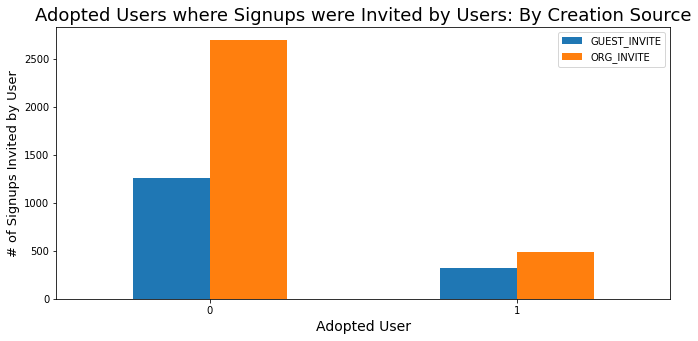

In [41]:
invited=df[df['invited_by_user']==1].groupby(['adopted_user'])['creation_source'].value_counts().unstack().fillna(0)
invited.plot.bar(figsize=(11,5))
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), fontsize='medium')
plt.xlabel('Adopted User', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('# of Signups Invited by User', fontsize=13)
plt.title('Adopted Users where Signups were Invited by Users: By Creation Source', fontsize=18, color='black')
plt.show()

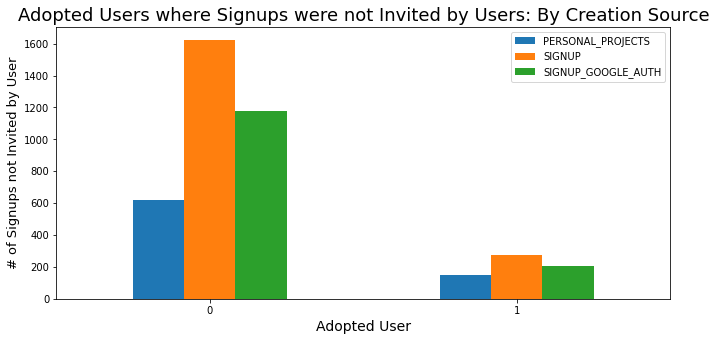

In [42]:
not_invited=df[df['invited_by_user']==0].groupby(['adopted_user'])['creation_source'].value_counts().unstack().fillna(0)
not_invited.plot.bar(figsize=(11,5))
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), fontsize='medium')
plt.xlabel('Adopted User', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('# of Signups not Invited by User', fontsize=13)
plt.title('Adopted Users where Signups were not Invited by Users: By Creation Source', fontsize=18, color='black')
plt.show()

In [44]:
drop_columns=['creation_time','last_session_creation_time']

df = df.drop(columns=drop_columns)


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     8823 non-null   int64  
 1   visited                     8823 non-null   int64  
 2   adopted_user                8823 non-null   int32  
 3   name                        8823 non-null   object 
 4   email                       8823 non-null   object 
 5   creation_source             8823 non-null   object 
 6   opted_in_to_mailing_list    8823 non-null   int64  
 7   enabled_for_marketing_drip  8823 non-null   int64  
 8   org_id                      8823 non-null   int64  
 9   invited_by_user_id          8823 non-null   float64
 10  invited_by_user             8823 non-null   int32  
 11  active_days                 8823 non-null   int32  
 12  active_years                8823 non-null   float64
dtypes: float64(2), int32(3), int64(5)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='adopted_user'), 
                                                    df.adopted_user, test_size=0.3, 
                                                    random_state=47)

In [47]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [48]:
final_iv, IV = data_vars(X_train, y_train)

C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mayra\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(6176, 5)

,active_days,active_years,creation_source,name,org_id
4042,262,0.72,GUEST_INVITE,Grandstaff Christopher,322
7969,504,1.38,GUEST_INVITE,Griffiths Amber,0
6767,0,0.00,SIGNUP_GOOGLE_AUTH,Hussain Billy,70
3430,1,0.00,GUEST_INVITE,Buckley Kyle,208
4097,0,0.00,ORG_INVITE,Decker Christian,252


In [50]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing active_days with VIF of 28997.337858
Iteration # 2
Complete


In [51]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

2

Index(['active_years', 'org_id'], dtype='object')

,active_years,org_id
4042,0.72,322
7969,1.38,0
6767,0.00,70
3430,0.00,208
4097,0.00,252


In [52]:
X_test=X_test[X_train.columns]
X_test.head()

,active_years,org_id
3334,0.00,14
1501,0.00,0
4471,0.03,35
6749,1.20,273
6099,0.00,391


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.89559561 0.10440439]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


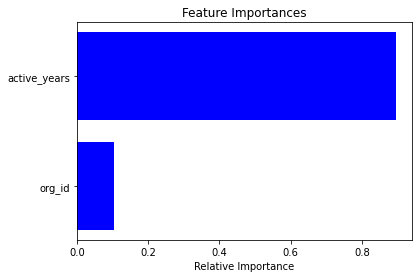

[[2153   41]
 [  50  403]]


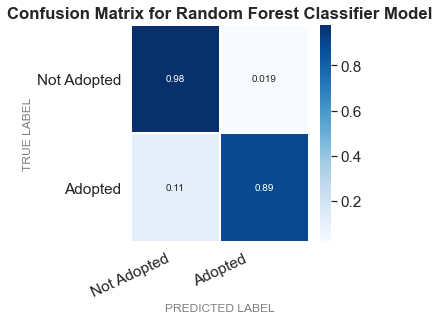

In [53]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:49, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



roc1 = roc_auc_score(y_test, y_pred1)

roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Not Adopted', 'Adopted']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('PREDICTED LABEL', fontsize=12, color='grey')
plt.ylabel('TRUE LABEL', fontsize=12, color='grey')
plt.title('Confusion Matrix for Random Forest Classifier Model',fontweight='bold')
plt.show()

In [54]:
roc1

0.9354686974912514

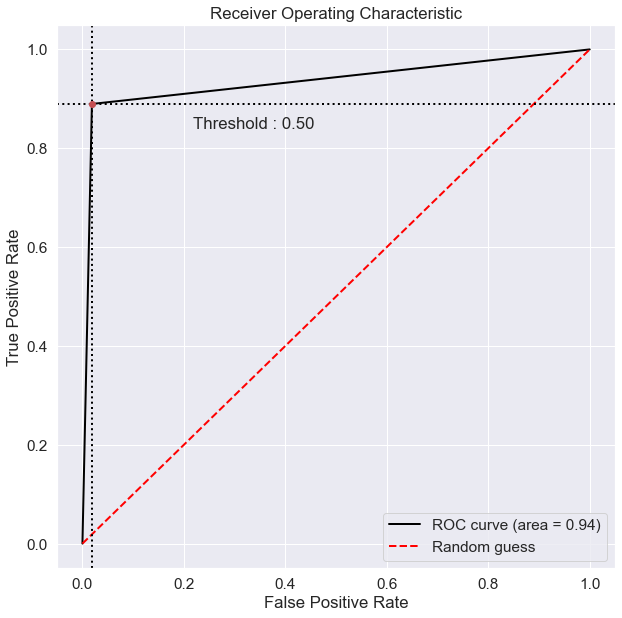

In [55]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred1, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

In [56]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=0, n_jobs=-1, oob_score=True)
xgb.fit(X_train, y_train)

y_pred2 = xgb.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

C:\Users\mayra\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9501439808749932

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


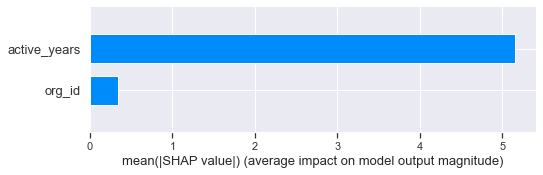

In [57]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")